In [153]:
import os
import shutil
 
original_dataset_dir = './cropData'
classes_list = os.listdir(original_dataset_dir) 
print(classes_list)
 
# 나눠진 베이스 디렉터토리
base_dir = './crop_splitted'

# 하위 경로의 모든 폴더 목목을 가져온다
os.mkdir(base_dir)
 
train_dir = os.path.join(base_dir, 'train') 
os.mkdir(train_dir)

validation_dir = os.path.join(base_dir, 'val')
os.mkdir(validation_dir)

test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

for cls in classes_list:     
    os.mkdir(os.path.join(train_dir, cls))
    os.mkdir(os.path.join(validation_dir, cls))
    os.mkdir(os.path.join(test_dir, cls))

['남성구두', '아디다스', '등산화', '무지', '휠라']


FileExistsError: [Errno 17] File exists: './crop_splitted'

In [154]:
classes_list=['남성구두', '등산화', '무지', '아디다스', '휠라']

In [155]:
import math
 
for cls in classes_list:
    path = os.path.join(original_dataset_dir, cls)
    fnames = os.listdir(path)

    # train Validation Test 비율 => 6:2:2
    
    train_size = math.floor(len(fnames) * 0.6)
    validation_size = math.floor(len(fnames) * 0.2)
    test_size = math.floor(len(fnames) * 0.2)
    
    train_fnames = fnames[:train_size]
    
    print("Train size(",cls,"): ", len(train_fnames))
    
    for fname in train_fnames:
        src = os.path.join(path, fname)
        dst = os.path.join(os.path.join(train_dir, cls), fname)
        shutil.copyfile(src, dst)
        
    validation_fnames = fnames[train_size:(validation_size + train_size)]
    print("Validation size(",cls,"): ", len(validation_fnames))
    
    for fname in validation_fnames:
        src = os.path.join(path, fname)
        dst = os.path.join(os.path.join(validation_dir, cls), fname)
        shutil.copyfile(src, dst)
        
    test_fnames = fnames[(train_size+validation_size):(validation_size + train_size +test_size)]

    print("Test size(",cls,"): ", len(test_fnames))
    for fname in test_fnames:
        src = os.path.join(path, fname)
        dst = os.path.join(os.path.join(test_dir, cls), fname)
        shutil.copyfile(src, dst)

Train size( 남성구두 ):  261
Validation size( 남성구두 ):  87
Test size( 남성구두 ):  87
Train size( 등산화 ):  222
Validation size( 등산화 ):  74
Test size( 등산화 ):  74
Train size( 무지 ):  275
Validation size( 무지 ):  91
Test size( 무지 ):  91
Train size( 아디다스 ):  223
Validation size( 아디다스 ):  74
Test size( 아디다스 ):  74
Train size( 휠라 ):  263
Validation size( 휠라 ):  87
Test size( 휠라 ):  87


In [156]:
import torch
import os
 
USE_CUDA = torch.cuda.is_available()
#DEVICE = torch.device("cuda:1" if USE_CUDA else "cpu")

#배치 사이즈를 5으로함 
BATCH_SIZE = 10

EPOCH = 100 
#print(DEVICE)

In [157]:
import os
import torch
import torch.nn as nn

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "0,1,2,3,4"

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print('Device:', DEVICE)  # 출력결과: cuda 
print('Count of using GPUs:', torch.cuda.device_count())   #출력결과: 2 (2, 3 두개 사용하므로)
print('Current cuda device:', torch.cuda.current_device())  # 출력결과: 2 (2, 3 중 앞의 GPU #2 의미)



Device: cuda:0
Count of using GPUs: 5
Current cuda device: 0


In [158]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder 

#  이미지 전처리를 위한 부분 리사이즈 함 64 * 64 이미지를 텐셔 형태로 변환함
transform_base = transforms.Compose([transforms.Resize((64,64)), transforms.ToTensor()]) 

# ImageFolder를 사용하여 데이터 셋을 불러옴 , transform 에는 어떻게 변환 할지 결정함 
train_dataset = ImageFolder(root='./crop_splitted/train', transform=transform_base) 
val_dataset = ImageFolder(root='./crop_splitted/val', transform=transform_base)


In [159]:
import torch
import torchvision
import torchvision.transforms as transforms

In [160]:
from torch.utils.data import DataLoader

# 주어진 데이터를 미니배치 단위로 분리함 shuffle 은 데이터 셋의 순서를 섞음
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=20)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=20)

tensor([3, 4, 3, 2, 1, 0, 4, 2, 2, 3])
아디다스  휠라    아디다스  무지    등산화   남성구두  휠라    무지    무지    아디다스 


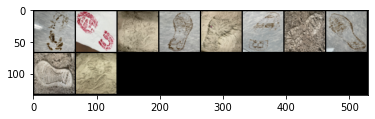

In [161]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(labels)

# 이미지 보여주기
plt.imshow(torchvision.utils.make_grid(images, normalize=True).permute(1,2,0))

# 정답(label) 출력
print(' '.join(f'{classes_list[labels[j]]:5s}' for j in range(BATCH_SIZE)))

In [162]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
 
class Net(nn.Module): 
  
    def __init__(self): 
    
        super(Net, self).__init__() 

        self.conv1 = nn.Conv2d(3, 32, 3, padding=1) 
        self.pool = nn.MaxPool2d(2,2)  
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)  
        self.conv3 = nn.Conv2d(64, 64, 3, padding=1)  

        self.fc1 = nn.Linear(4096, 512) 
        self.fc2 = nn.Linear(512, 5) 
    
    def forward(self, x):  
    
        x = self.conv1(x)
        x = F.relu(x)  
        x = self.pool(x) 
        x = F.dropout(x, p=0.25, training=self.training) 

        x = self.conv2(x)
        x = F.relu(x) 
        x = self.pool(x) 
        x = F.dropout(x, p=0.25, training=self.training)

        x = self.conv3(x) 
        x = F.relu(x) 
        x = self.pool(x) 
        x = F.dropout(x, p=0.25, training=self.training)

        x = x.view(-1, 4096)  
        x = self.fc1(x) 
        x = F.relu(x) 
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc2(x) 

        return F.log_softmax(x, dim=1)  
    
print(DEVICE)

#model_base = Net().to(DEVICE)  

#멀티로 GPU를 사용하

_net = Net().cuda()
model_base = nn.DataParallel(_net).to(DEVICE)
optimizer = optim.Adam(model_base.parameters(), lr=0.001) 

cuda:0


In [163]:
def train(model, train_loader, optimizer):
    model.train()  
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE) 
        optimizer.zero_grad() 
        output = model(data)  
        loss = F.cross_entropy(output, target) 
        loss.backward()  
        optimizer.step()  

In [164]:
def evaluate(model, test_loader):
    model.eval()  
    test_loss = 0 
    
    #맞은 갯수를 샘
    correct = 0   
    
    with torch.no_grad(): 
        for data, target in test_loader:  
            data, target = data.to(DEVICE), target.to(DEVICE)  
            
            #모델에 데이터를  넣어 결과를 구함
            output = model(data) 
            
            test_loss += F.cross_entropy(output,target, reduction='sum').item() 
 
            
            pred = output.max(1, keepdim=True)[1]
            #print("정답={}".format(pred))
            
            # 정답이 일치하면 1 일치 하지 않으면 0 
            #print(pred.eq(target.view_as(pred)).sum().item())
            correct += pred.eq(target.view_as(pred)).sum().item() 
   
    test_loss /= len(test_loader.dataset) 
    test_accuracy = 100. * correct / len(test_loader.dataset) 
    return test_loss, test_accuracy  

In [165]:
import time
import copy

train_acc_list =[]
val_acc_list =[]
 
def train_baseline(model ,train_loader, val_loader, optimizer, num_epochs):
    best_acc = 0.0  
    best_model_wts = copy.deepcopy(model.state_dict()) 
 
    for epoch in range(1, num_epochs + 1):
        since = time.time() 
        #print(since)
        train(model, train_loader, optimizer)
        train_loss, train_acc = evaluate(model, train_loader) 
        val_loss, val_acc = evaluate(model, val_loader)
        
        if val_acc > best_acc: 
            best_acc = val_acc 
            best_model_wts = copy.deepcopy(model.state_dict())
        
        time_elapsed = time.time() - since 
        
        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)
        
        print('-------------- epoch {} ----------------'.format(epoch))
        print('train Loss: {:.4f}, Accuracy: {:.2f}%'.format(train_loss, train_acc))   
        print('val Loss: {:.4f}, Accuracy: {:.2f}%'.format(val_loss, val_acc))
        print('Completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60)) 
    model.load_state_dict(best_model_wts)  
    return model

In [25]:
base = train_baseline(model_base, train_loader, val_loader, optimizer, 200)  	 #(16)e,'baseline.pt')


-------------- epoch 1 ----------------
train Loss: 1.6083, Accuracy: 21.38%
val Loss: 1.6083, Accuracy: 21.31%
Completed in 0m 19s
-------------- epoch 2 ----------------
train Loss: 1.6070, Accuracy: 22.11%
val Loss: 1.6072, Accuracy: 22.03%
Completed in 0m 19s
-------------- epoch 3 ----------------
train Loss: 1.6081, Accuracy: 22.11%
val Loss: 1.6084, Accuracy: 22.03%
Completed in 0m 19s
-------------- epoch 4 ----------------
train Loss: 1.6041, Accuracy: 22.91%
val Loss: 1.6050, Accuracy: 20.34%
Completed in 0m 19s
-------------- epoch 5 ----------------
train Loss: 1.5965, Accuracy: 22.99%
val Loss: 1.5973, Accuracy: 20.58%
Completed in 0m 19s
-------------- epoch 6 ----------------
train Loss: 1.5705, Accuracy: 27.09%
val Loss: 1.5754, Accuracy: 26.39%
Completed in 0m 19s
-------------- epoch 7 ----------------
train Loss: 1.4553, Accuracy: 29.74%
val Loss: 1.4757, Accuracy: 27.36%
Completed in 0m 19s
-------------- epoch 8 ----------------
train Loss: 1.4278, Accuracy: 36.58%

-------------- epoch 63 ----------------
train Loss: 0.0094, Accuracy: 100.00%
val Loss: 0.6325, Accuracy: 88.86%
Completed in 0m 19s
-------------- epoch 64 ----------------
train Loss: 0.0058, Accuracy: 100.00%
val Loss: 0.4536, Accuracy: 89.83%
Completed in 0m 19s
-------------- epoch 65 ----------------
train Loss: 0.0032, Accuracy: 100.00%
val Loss: 0.4891, Accuracy: 89.83%
Completed in 0m 19s
-------------- epoch 66 ----------------
train Loss: 0.0024, Accuracy: 100.00%
val Loss: 0.5025, Accuracy: 90.56%
Completed in 0m 19s
-------------- epoch 67 ----------------
train Loss: 0.0027, Accuracy: 99.92%
val Loss: 0.4946, Accuracy: 90.80%
Completed in 0m 19s
-------------- epoch 68 ----------------
train Loss: 0.0015, Accuracy: 100.00%
val Loss: 0.5694, Accuracy: 89.10%
Completed in 0m 19s
-------------- epoch 69 ----------------
train Loss: 0.0023, Accuracy: 100.00%
val Loss: 0.5661, Accuracy: 88.62%
Completed in 0m 19s
-------------- epoch 70 ----------------
train Loss: 0.0046, Ac

-------------- epoch 125 ----------------
train Loss: 0.0007, Accuracy: 100.00%
val Loss: 0.4332, Accuracy: 91.28%
Completed in 0m 19s
-------------- epoch 126 ----------------
train Loss: 0.0036, Accuracy: 100.00%
val Loss: 0.4974, Accuracy: 90.56%
Completed in 0m 19s
-------------- epoch 127 ----------------
train Loss: 0.0007, Accuracy: 100.00%
val Loss: 0.4927, Accuracy: 90.31%
Completed in 0m 19s
-------------- epoch 128 ----------------
train Loss: 0.0024, Accuracy: 100.00%
val Loss: 0.3820, Accuracy: 90.80%
Completed in 0m 19s
-------------- epoch 129 ----------------
train Loss: 0.0007, Accuracy: 100.00%
val Loss: 0.3575, Accuracy: 91.28%
Completed in 0m 19s
-------------- epoch 130 ----------------
train Loss: 0.0004, Accuracy: 100.00%
val Loss: 0.4192, Accuracy: 91.28%
Completed in 0m 19s
-------------- epoch 131 ----------------
train Loss: 0.0002, Accuracy: 100.00%
val Loss: 0.5286, Accuracy: 92.01%
Completed in 0m 19s
-------------- epoch 132 ----------------
train Loss: 0

-------------- epoch 186 ----------------
train Loss: 0.0002, Accuracy: 100.00%
val Loss: 0.4104, Accuracy: 91.77%
Completed in 0m 19s
-------------- epoch 187 ----------------
train Loss: 0.0023, Accuracy: 100.00%
val Loss: 0.4438, Accuracy: 89.83%
Completed in 0m 19s
-------------- epoch 188 ----------------
train Loss: 0.0002, Accuracy: 100.00%
val Loss: 0.4617, Accuracy: 91.28%
Completed in 0m 19s
-------------- epoch 189 ----------------
train Loss: 0.0006, Accuracy: 100.00%
val Loss: 0.4886, Accuracy: 91.28%
Completed in 0m 19s
-------------- epoch 190 ----------------
train Loss: 0.0001, Accuracy: 100.00%
val Loss: 0.4339, Accuracy: 92.98%
Completed in 0m 19s
-------------- epoch 191 ----------------
train Loss: 0.0003, Accuracy: 100.00%
val Loss: 0.4426, Accuracy: 92.01%
Completed in 0m 18s
-------------- epoch 192 ----------------
train Loss: 0.0392, Accuracy: 98.23%
val Loss: 0.6374, Accuracy: 86.92%
Completed in 0m 19s
-------------- epoch 193 ----------------
train Loss: 0.

In [26]:
torch.save(base,'baseline_crop_200.pt') #100 epoch

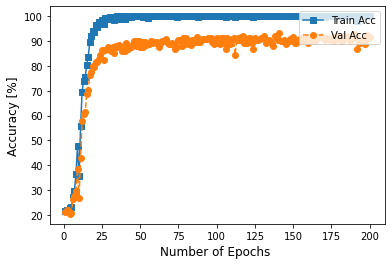

In [27]:
import matplotlib.pyplot as plt

x_data = []

for i in range(1, 201):
    x_data.append(i)

plt.xlabel('Number of Epochs ', fontsize=12)  # x축 제목
plt.ylabel('Accuracy [%]', fontsize=12)  # y 축 제목


plt.errorbar(x_data, train_acc_list, capsize=4, marker='s', linestyle='-', label="Train Acc")
plt.errorbar(x_data, val_acc_list, capsize=4, marker='o', linestyle='--', label="Val Acc")

plt.legend(loc='upper right')

#plt.savefig(fname='figure5a.eps', bbox_inches='tight', pad_inches=0)

plt.show()

In [166]:
data_transforms = {
    'train': transforms.Compose([transforms.Resize([64,64]), 
        transforms.RandomHorizontalFlip(), transforms.RandomVerticalFlip(),  
        transforms.RandomCrop(52), transforms.ToTensor(), 
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ]),
    
    'val': transforms.Compose([transforms.Resize([64,64]),  
        transforms.RandomCrop(52), transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ])
}

In [167]:
data_dir = './splitted' 
image_datasets = {x: ImageFolder(root=os.path.join(data_dir, x), transform=data_transforms[x]) for x in ['train', 'val']} 
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=4) for x in ['train', 'val']} 
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

FileNotFoundError: [Errno 2] No such file or directory: './splitted/train'

In [168]:
from torchvision import models
 
resnet = models.resnet50(pretrained=True)  
num_ftrs = resnet.fc.in_features   
resnet.fc = nn.Linear(num_ftrs, 5) 

#resnet = resnet.to(DEVICE)

_net = resnet.cuda()
resnet_model = nn.DataParallel(_net).to(DEVICE)
 
criterion = nn.CrossEntropyLoss() 
optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, resnet.parameters()), lr=0.001)
 
from torch.optim import lr_scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1) 

In [169]:
ct = 0 
for child in resnet.children():  
    ct += 1  
    
    #몇 번 레이어 부터 잠글 것인가 
    if ct < 3: 
        for param in child.parameters():
            param.requires_grad = False
    print(ct)

1
2
3
4
5
6
7
8
9
10


In [36]:
train_acc_list2 =[]
val_acc_list2 =[]

def train_resnet(model, criterion, optimizer, scheduler, num_epochs=25):
    

    best_model_wts = copy.deepcopy(model.state_dict())  
    best_acc = 0.0  
    
    for epoch in range(num_epochs):
        print('-------------- epoch {} ----------------'.format(epoch+1)) 
        since = time.time()                                     
        for phase in ['train', 'val']: 
            if phase == 'train': 
                model.train() 
            else:
                model.eval()     
 
            running_loss = 0.0  
            running_corrects = 0  
 
            
            for inputs, labels in dataloaders[phase]: 
                inputs = inputs.to(DEVICE)  
                labels = labels.to(DEVICE)  
                
                optimizer.zero_grad() 
                
                with torch.set_grad_enabled(phase == 'train'):  
                    outputs = model(inputs)  
                    _, preds = torch.max(outputs, 1) 
                    loss = criterion(outputs, labels)  
    
                    if phase == 'train':   
                        loss.backward()
                        optimizer.step()
 
                running_loss += loss.item() * inputs.size(0)  
                running_corrects += torch.sum(preds == labels.data)  
            if phase == 'train':  
                scheduler.step()
 
            epoch_loss = running_loss/dataset_sizes[phase]  
            epoch_acc = running_corrects.double()/dataset_sizes[phase]  
 
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc)) 
 
          
            if phase == 'val' and epoch_acc > best_acc: 
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
 
        time_elapsed = time.time() - since  
        print('Completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
 
    model.load_state_dict(best_model_wts) 

    return model

In [23]:
model_resnet50 = train_resnet(resnet_model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30) 


-------------- epoch 1 ----------------
train Loss: 1.7061 Acc: 0.2495
val Loss: 1.6005 Acc: 0.2393
Completed in 3m 0s
-------------- epoch 2 ----------------
train Loss: 1.6858 Acc: 0.2665
val Loss: 1.5930 Acc: 0.3086
Completed in 2m 48s
-------------- epoch 3 ----------------
train Loss: 1.5619 Acc: 0.2758
val Loss: 1.6490 Acc: 0.2789
Completed in 2m 42s
-------------- epoch 4 ----------------
train Loss: 1.4544 Acc: 0.3231
val Loss: 1.5854 Acc: 0.2343
Completed in 2m 44s
-------------- epoch 5 ----------------
train Loss: 1.4063 Acc: 0.3527
val Loss: 1.5716 Acc: 0.2954
Completed in 2m 46s
-------------- epoch 6 ----------------
train Loss: 1.3256 Acc: 0.3901
val Loss: 1.7074 Acc: 0.2706
Completed in 2m 45s
-------------- epoch 7 ----------------
train Loss: 1.2773 Acc: 0.4055
val Loss: 1.6539 Acc: 0.2739
Completed in 2m 47s
-------------- epoch 8 ----------------
train Loss: 1.0887 Acc: 0.4802
val Loss: 1.4242 Acc: 0.3350
Completed in 2m 49s
-------------- epoch 9 ----------------
t

In [24]:
torch.save(model_resnet50, 'resnet50_30.pt')

ValueError: 'x' and 'y' must have the same size

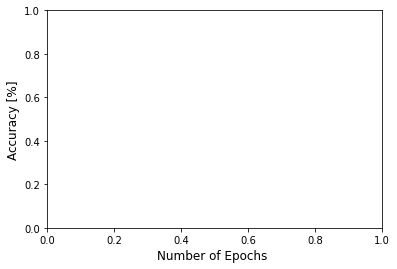

In [37]:
import matplotlib.pyplot as plt

x_data = []

for i in range(1, 31):
    x_data.append(i)

plt.xlabel('Number of Epochs ', fontsize=12)  # x축 제목
plt.ylabel('Accuracy [%]', fontsize=12)  # y 축 제목


plt.errorbar(x_data, train_acc_list2, capsize=4, marker='s', linestyle='-', label="Train Acc")
plt.errorbar(x_data, val_acc_list2, capsize=4, marker='o', linestyle='--', label="Val Acc")

plt.legend(loc='upper right')

#plt.savefig(fname='figure5a.eps', bbox_inches='tight', pad_inches=0)

plt.show()

In [170]:
transform_base = transforms.Compose([transforms.Resize([64,64]),transforms.ToTensor()])
test_base = ImageFolder(root='./crop_splitted/test',transform=transform_base)  
test_loader_base = torch.utils.data.DataLoader(test_base, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

In [171]:
transform_resNet = transforms.Compose([
        transforms.Resize([64,64]),  
        transforms.RandomCrop(52),  
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
    ])
    
test_resNet = ImageFolder(root='./splitted/test', transform=transform_resNet) 
test_loader_resNet = torch.utils.data.DataLoader(test_resNet, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

FileNotFoundError: [Errno 2] No such file or directory: './splitted/test'

In [190]:
baseline=torch.load('baseline_100.pt') 
baseline.eval()  
test_loss, test_accuracy = evaluate(baseline, test_loader_base)

print('baseline test acc:  ', test_accuracy)

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f080fac8950>
Traceback (most recent call last):
  File "/home/patrick/.conda/envs/myenv/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/patrick/.conda/envs/myenv/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home/patrick/.conda/envs/myenv/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f080fac8950>
Traceback (most recent call last):
  File "/home/patrick/.conda/envs/myenv/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/patrick/.conda/envs/myenv/lib/python3.7/site-packag

baseline test acc:   20.09685230024213


In [172]:
baseline=torch.load('baseline_crop_200.pt') 
baseline.eval()  
test_loss, test_accuracy = evaluate(baseline, test_loader_base)

print('baseline test acc:  ', test_accuracy)

baseline test acc:   93.46246973365618


In [173]:
# 각 분류(class)에 대한 예측값 계산을 위해 준비
correct_pred = {classname: 0 for classname in classes_list}
total_pred = {classname: 0 for classname in classes_list}
def class_evaluate(model, test_loader):
    
    # 변화도는 여전히 필요하지 않습니다
    with torch.no_grad():
        for data,target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            
            pred = output.max(1, keepdim=True)[1]
            # 각 분류별로 올바른 예측 수를 모읍니다
            
            for label, prediction in zip(target, pred):
                if label == prediction:
                    correct_pred[classes_list[label]] += 1
                total_pred[classes_list[label]] += 1


    # 각 분류별 정확도(accuracy)를 출력합니다
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

In [174]:
baseline=torch.load('baseline_crop_200.pt') 
baseline.eval()  
class_evaluate(baseline, test_loader_base)

Accuracy for class: 남성구두  is 93.1 %
Accuracy for class: 등산화   is 95.9 %
Accuracy for class: 무지    is 94.5 %
Accuracy for class: 아디다스  is 86.5 %
Accuracy for class: 휠라    is 96.6 %


In [42]:
resnet50=torch.load('resnet50.pt') 
resnet50.eval()  
test_loss, test_accuracy = evaluate(resnet50, test_loader_resNet)

print('ResNet test acc:  ', test_accuracy)

ResNet test acc:   96.8543046357616


In [45]:
resnet50=torch.load('resnet50_200.pt') 
resnet50.eval()  
test_loss, test_accuracy = evaluate(resnet50, test_loader_resNet)

print('ResNet test acc:  ', test_accuracy)

ResNet test acc:   38.90728476821192


In [43]:

resnet50=torch.load('resnet50.pt') 
resnet50.eval()  
class_evaluate(resnet50, test_loader_resNet)

Accuracy for class: 남성구두  is 79.3 %
Accuracy for class: 등산화   is 77.7 %
Accuracy for class: 무지    is 88.2 %
Accuracy for class: 아디다스  is 84.3 %
Accuracy for class: 휠라    is 78.6 %


In [188]:
from sklearn.metrics import confusion_matrix ,accuracy_score, precision_score, recall_score, confusion_matrix, f1_score
import seaborn as sn
import pandas as pd
import numpy as np
import math
def print_confusion_matrix(model, test_loader):
    y_pred = []
    y_true = []
    row_sum = []

    # 변화도는 여전히 필요하지 않습니다
    with torch.no_grad():
        
        for data,target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            
            # output
            output = model(data) # Feed Network
            
            pred = output.max(1, keepdim=True)[1]
            # 각 분류별로 올바른 예측 수를 모읍니다
            
            y_pred.extend(pred.cpu().numpy()) # savs prediction
                         
            labels = target.cpu().numpy()
            y_true.extend(labels) # Save Truth
            
    # constant for classes
    classes = ('Man', 'Adidas', 'Hiking', 'MUJI', 'FILA')
    
    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)
    
    for value in cf_matrix.sum(axis=1):
        row_sum.append([value])
    # 전부 데이터가 같을 경우임!
#     df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *4, index = [i for i in classes],
#                          columns = [i for i in classes])
    df_cm = pd.DataFrame(cf_matrix/row_sum, index = [i for i in classes],
                         columns = [i for i in classes])
    plt.figure(figsize = (12,7))
    sn.heatmap(df_cm, annot=True)
    plt.savefig('output.png')  
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    
    #f1 = precision_re
    print('Accuray is {}'.format(accuracy))
    print('Precision is {}'.format(precision))
    print('Recall is {}'.format(recall))    
    print('F1 Score is {}'.format(f1))  
        
    # presition 

Accuray is 0.9346246973365617
Precision is 0.9350691770672237
Recall is 0.9331861987034401
F1 Score is 0.933618746686091


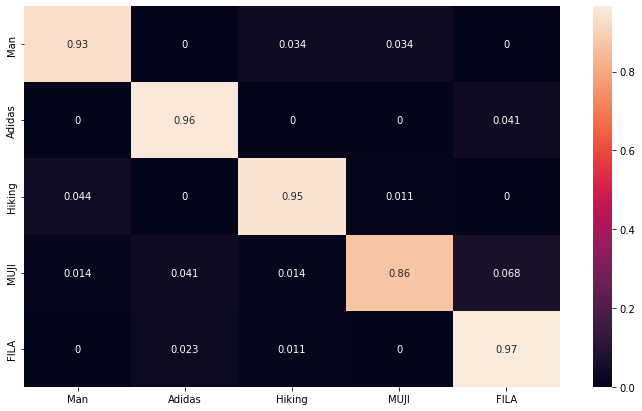

In [189]:
print_confusion_matrix(baseline, test_loader_base)

In [73]:
#from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
#from sklearn.metrics import accuracy_score

# 학습 데이터와 훈련 데이터 split
X_train, X_test, y_train, y_test = train_test_split(dataset, y, test_size = 0.2, random_state = 42, shuffle = True)

# confusion matrix
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import matplotlib.pyplot as plt

label=['anger', 'happiness', 'fear', 'sadness', 'neutral'] # 라벨 설정
plot = plot_confusion_matrix(clf, # 분류 모델
                             X_test_scaled, y_test, # 예측 데이터와 예측값의 정답(y_true)
                             display_labels=label, # 표에 표시할 labels
                             cmap=plt.cm.Blue, # 컬러맵(plt.cm.Reds, plt.cm.rainbow 등이 있음)
                             normalize=None) # 'true', 'pred', 'all' 중에서 지정 가능. default=None
plot.ax_.set_title('Confusion Matrix')

NameError: name 'dataset' is not defined

In [61]:
pip install torchmetrics

Note: you may need to restart the kernel to use updated packages.


In [62]:
from torchmetrics import F1Score

In [67]:
from torchmetrics import F1Score # import 해줍니다.

f1 = F1Score(num_classes=18) # num_classes의 값으로 18을 주고 인스턴스를 생성합니다.

...

with torch.no_grad():
        f1_score = 0
        for k, (img, target) in enumerate(test_loader_base): 
            img, target = img.to(DEVICE), target.to(DEVICE)

            output = baseline(img).to(DEVICE) # 에측할 이미지를 모델에 넣어서 output을 얻어냅니다
            pred = output.argmax(dim=1).to(DEVICE) # pred로 한번 변경 해줍니다
            target = target.view_as(pred).to(DEVICE) # 각자 본인들의 code에 맞는 target 값을 구해줍니다

            f1_score += f1(pred, target) # 위에서만든 f1 인스턴스를 이용해 f1_score를 합산해줍니다
        f1_score /= len(valid_dataset) # 저는 평균을 구하기 위해 나눠주었습니다
        
        print(f1_score)

RuntimeError: Encountered different devices in metric calculation (see stacktrace for details).This could be due to the metric class not being on the same device as input.Instead of `metric=F1Score(...)` try to do `metric=F1Score(...).to(device)` where device corresponds to the device of the input.